In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import seaborn as sns

from scripts.helper import toBin, toDec, padList

# Integer Division:

$f(a, b) = [\text{quotient}(a,b) ,  \text{remainder}(a,b)], \space a,b \in \mathbb{N}_{[1,2000]}$

## Data Generation

In [2]:
lb = 1
ub_a = 2000
ub_b = 2000

n_digits = int(np.ceil(np.log2(ub_a)))
n_train = 50000 
n_test = 20000
n_val = 20000

X_train = np.random.randint(lb, (ub_a, ub_b), (n_train,2))
y_train = [divmod(x,y) for x,y in X_train]

X_test = np.random.randint(lb, (ub_a, ub_b), (n_test,2))
y_test = [divmod(x,y) for x,y in X_test]

X_val = np.random.randint(lb, (ub_a, ub_b), (n_val,2))
y_val = [divmod(x,y) for x,y in X_val]

Inputs are individually converted from integers into binary and concated together.
E.g. $[a,b] = [164, 403] \rightarrow [[0, 0, 1, 0, 1, 0, 0, 1, 0, 0], [0, 1, 1, 0, 0, 1, 0, 0, 1, 1]] \rightarrow [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1]$. Similarly for the output of the quotient and remainder.

In [3]:
#converting data to binary
X_train = tf.stack([padList(toBin(x), n_digits) + padList(toBin(y), n_digits) for x, y in X_train])
y_train = tf.stack([padList(toBin(x), n_digits) + padList(toBin(y), n_digits) for x, y in y_train])

X_test = tf.stack([padList(toBin(x), n_digits) + padList(toBin(y), n_digits) for x,y  in X_test])
y_test = tf.stack([padList(toBin(x), n_digits) + padList(toBin(y), n_digits) for x,y in y_test])

X_val = tf.stack([padList(toBin(x), n_digits) + padList(toBin(y), n_digits) for x,y  in X_val])

## Neurel Net

In [4]:
path = 'C:/Users/Puri/Desktop/repos/Untitled Folder/callbacks'

callback1 = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)
callback2 = keras.callbacks.ModelCheckpoint(filepath = path, monitor='val_loss', save_best_only=True, save_weights_only=True)

model = keras.models.Sequential([
    keras.layers.Input(shape = (2 * n_digits)),
    keras.layers.Dense(1000, activation = 'relu', kernel_constraint = keras.constraints.MaxNorm(3)),
    tf.keras.layers.Dropout(.2),
    keras.layers.Dense(500, activation = 'sigmoid', kernel_constraint = keras.constraints.MaxNorm(3)),
    tf.keras.layers.Dropout(.2),
    keras.layers.Dense(250, activation = tf.math.cos, kernel_constraint = keras.constraints.MaxNorm(3)),
    tf.keras.layers.Dropout(.2),
    keras.layers.Dense(100, activation = tf.math.sin, kernel_constraint = keras.constraints.MaxNorm(3)),
    tf.keras.layers.Dropout(.2),
    keras.layers.Dense(2 * n_digits, activation = 'sigmoid')
])
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.01), 'mean_squared_error')

model.fit(X_train, y_train, batch_size = 1000, epochs = 10000, 
          validation_data = (X_test, y_test),
         callbacks = [callback1, callback2]
         )

model.load_weights(path)

Epoch 1/10000
50/50 [==============================] - 4s 69ms/step - loss: 0.1618 - val_loss: 0.1276
Epoch 2/10000
50/50 [==============================] - 3s 68ms/step - loss: 0.1127 - val_loss: 0.0866
Epoch 3/10000
50/50 [==============================] - 3s 66ms/step - loss: 0.0850 - val_loss: 0.0646
Epoch 4/10000
50/50 [==============================] - 4s 70ms/step - loss: 0.0742 - val_loss: 0.0612
Epoch 5/10000
50/50 [==============================] - 3s 67ms/step - loss: 0.0679 - val_loss: 0.0563
Epoch 6/10000
50/50 [==============================] - 3s 67ms/step - loss: 0.0644 - val_loss: 0.0536
Epoch 7/10000
50/50 [==============================] - 3s 66ms/step - loss: 0.0611 - val_loss: 0.0505
Epoch 8/10000
50/50 [==============================] - 3s 62ms/step - loss: 0.0589 - val_loss: 0.0507
Epoch 9/10000
50/50 [==============================] - 3s 69ms/step - loss: 0.0575 - val_loss: 0.0466
Epoch 10/10000
50/50 [==============================] - 3s 67ms/step - loss: 0.055

50/50 [==============================] - 3s 60ms/step - loss: 0.0277 - val_loss: 0.0200
Epoch 81/10000
50/50 [==============================] - 3s 64ms/step - loss: 0.0273 - val_loss: 0.0188
Epoch 82/10000
50/50 [==============================] - 3s 61ms/step - loss: 0.0275 - val_loss: 0.0190
Epoch 83/10000
50/50 [==============================] - 3s 59ms/step - loss: 0.0271 - val_loss: 0.0193
Epoch 84/10000
50/50 [==============================] - 3s 64ms/step - loss: 0.0270 - val_loss: 0.0191
Epoch 85/10000
50/50 [==============================] - 3s 60ms/step - loss: 0.0265 - val_loss: 0.0188
Epoch 86/10000
50/50 [==============================] - 3s 60ms/step - loss: 0.0269 - val_loss: 0.0191
Epoch 87/10000
50/50 [==============================] - 3s 65ms/step - loss: 0.0265 - val_loss: 0.0183
Epoch 88/10000
50/50 [==============================] - 3s 61ms/step - loss: 0.0266 - val_loss: 0.0187
Epoch 89/10000
50/50 [==============================] - 3s 63ms/step - loss: 0.0263 - va

50/50 [==============================] - 3s 64ms/step - loss: 0.0240 - val_loss: 0.0171
Epoch 160/10000
50/50 [==============================] - 3s 59ms/step - loss: 0.0236 - val_loss: 0.0168
Epoch 161/10000
50/50 [==============================] - 3s 64ms/step - loss: 0.0241 - val_loss: 0.0165
Epoch 162/10000
50/50 [==============================] - 3s 62ms/step - loss: 0.0239 - val_loss: 0.0168
Epoch 163/10000
50/50 [==============================] - 3s 59ms/step - loss: 0.0242 - val_loss: 0.0172
Epoch 164/10000
50/50 [==============================] - 3s 62ms/step - loss: 0.0242 - val_loss: 0.0166
Epoch 165/10000
50/50 [==============================] - 3s 66ms/step - loss: 0.0239 - val_loss: 0.0164
Epoch 166/10000
50/50 [==============================] - 3s 62ms/step - loss: 0.0239 - val_loss: 0.0169
Epoch 167/10000
50/50 [==============================] - 3s 59ms/step - loss: 0.0240 - val_loss: 0.0167
Epoch 168/10000
50/50 [==============================] - 3s 59ms/step - loss: 0.

Epoch 238/10000
50/50 [==============================] - 3s 62ms/step - loss: 0.0230 - val_loss: 0.0166
Epoch 239/10000
50/50 [==============================] - 3s 61ms/step - loss: 0.0232 - val_loss: 0.0164
Epoch 240/10000
50/50 [==============================] - 3s 60ms/step - loss: 0.0228 - val_loss: 0.0155
Epoch 241/10000
50/50 [==============================] - 3s 60ms/step - loss: 0.0233 - val_loss: 0.0161
Epoch 242/10000
50/50 [==============================] - 3s 61ms/step - loss: 0.0236 - val_loss: 0.0174
Epoch 243/10000
50/50 [==============================] - 3s 64ms/step - loss: 0.0229 - val_loss: 0.0157
Epoch 244/10000
50/50 [==============================] - 3s 61ms/step - loss: 0.0235 - val_loss: 0.0164
Epoch 245/10000
50/50 [==============================] - 3s 60ms/step - loss: 0.0232 - val_loss: 0.0160
Epoch 246/10000
50/50 [==============================] - 3s 59ms/step - loss: 0.0232 - val_loss: 0.0162
Epoch 247/10000
50/50 [==============================] - 3s 59ms

Epoch 317/10000
50/50 [==============================] - 3s 63ms/step - loss: 0.0229 - val_loss: 0.0162
Epoch 318/10000
50/50 [==============================] - 3s 59ms/step - loss: 0.0227 - val_loss: 0.0155
Epoch 319/10000
50/50 [==============================] - 3s 59ms/step - loss: 0.0230 - val_loss: 0.0162
Epoch 320/10000
50/50 [==============================] - 3s 59ms/step - loss: 0.0228 - val_loss: 0.0158
Epoch 321/10000
50/50 [==============================] - 3s 59ms/step - loss: 0.0226 - val_loss: 0.0164
Epoch 322/10000
50/50 [==============================] - 3s 63ms/step - loss: 0.0229 - val_loss: 0.0158
Epoch 323/10000
50/50 [==============================] - 3s 60ms/step - loss: 0.0227 - val_loss: 0.0161
Epoch 324/10000
50/50 [==============================] - 3s 59ms/step - loss: 0.0223 - val_loss: 0.0154


Note the cosine and sine activation layers were significantly beneficial, likely due to the cyclic nature of the remainder.

## Validation

We look at the reconstruction error of the divident.  i.e. $\text{error} = a - (qb + r)$ where $q = \text{quotient}(a,b), \space r = \text{remainder}(a,b)$

In [5]:
y_val_hat = [[round(x) for x in y] for y in model.predict(X_val)]
y_val_hat = [(toDec(y[0:n_digits]), toDec(y[n_digits:])) for y in y_val_hat]
X_val = [(toDec(x[0:n_digits]), toDec(x[n_digits:])) for x in X_val.numpy()]

error = [((x[0] - y[1] - (x[1] * y[0])), (x[0] - y[1] - (x[1] * y[0]))/ x[0]) for x, y in zip(X_val, y_val_hat)]

625/625 [==============================] - 1s 2ms/step


In [21]:
print('Mean Absolute Percentage Error:', str(round(np.mean(np.abs([e[1] for e in error]) * 100),3)) + '%',)
print('Mean Absolute Percentage Error (a > 1000):', str(round(np.mean(np.abs([e[1] for e,x in zip(error, X_val) if x[0] > 1000]) * 100),3)) + '%',)
print('Mean Absolute Percentage Error (a > 1500):', str(round(np.mean(np.abs([e[1] for e,x in zip(error, X_val) if x[0] > 1500]) * 100),3)) + '%',)
print('Mean Absolute Percentage Error (a > 1750):', str(round(np.mean(np.abs([e[1] for e,x in zip(error, X_val) if x[0] > 1750]) * 100),3)) + '%',)

Mean Absolute Percentage Error: 2.735%
Mean Absolute Percentage Error (a > 1000): 3.395%
Mean Absolute Percentage Error (a > 1500): 3.427%
Mean Absolute Percentage Error (a > 1750): 3.694%


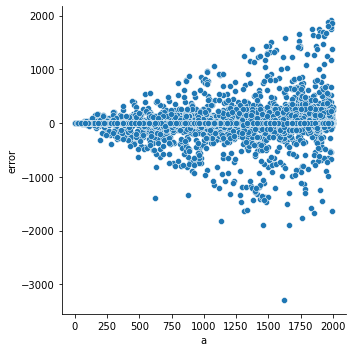

In [8]:
plot = sns.relplot(x = [x[0] for x in X_val], y = [e[0] for e in error])
plot.set(xlabel = 'a', ylabel = 'error')

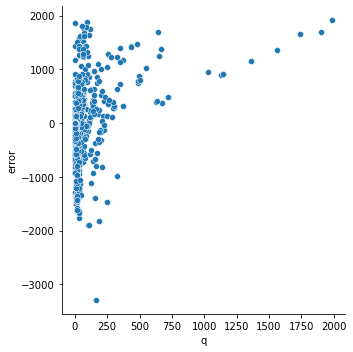

In [20]:
plot = sns.relplot(x = [y[0] for y in y_val], y = [e[0] for e in error])
plot.set(xlabel = 'q', ylabel = 'error')

Expected error is low  (and increases with $a$), but the variance is high. Note that using sine and cosine activation functions in the middle layers (as opposed to Relu) significantly decreased the varianace. How can we reduce it further?
